# Privacy Preserving Machine Learning

Some of codes are borrowed from Aurélien Bellet, http://researchers.lille.inria.fr/abellet/teaching/private_machine_learning_course.html

Recent success of deep learning makes us available to build many useful applications in computer vision, natural language processing, and recommender systems. As the deep learning is built upon the large amount of training data, the demands for security and privacy also grows. It is worth mentioning that all the data provider wants to protect the privacy.
However, for the modern deep neural networks, there exists lots of work to threat the privacy. For instance, one can verify whether a data is used for training or not (membership inference \[3\]) or reconstruct the data through its gradient over model parameters \[4\]. This is not just the case for the specific models or training algorithms, so there needs the general and impactful methodologies to achieve privacy.

Then, what is privacy and how to protect it? In Wikipedia, *privacy* is the ability of an indiivdual or group to seclude themselves or information about themselves, and thereby express themselves selectively. So if we want to justify that our model is safe under such privacy threat, any bad guy cannot specify the data or user by analyzing the model. This is somewhat hard for us (data scientist or machine learning engineer) since our goal is to leverage the modality to obtain some useful statistical patterns, and this is also correlated with privacy. Same line of discussion is already done in the security domain, and the study of privacy can be written by *dealing with performance and privacy*.

In this notes, we would study the methods how to privatize the training data of our model. At the end of the study, we can perform the private learning called **DP-SGD** with PyTorch, and evaluate them on the membership inference threat.

# Differential Privacy

To begin, let us discuss about the mathematical definition of privacy, called differential privacy. We give the formal definition of differnetial privacy below.

*Definition (differential privacy)* A randomized mechanism $\mathcal{M}:\mathcal{\Pi} \rightarrow \mathcal{R}$ with domain $\mathcal{\Pi}$ and range $\mathcal{R}$ satisfies **$(\epsilon,\delta)$-differential privacy** for any to adjacent inputs $D,D' \in \mathcal{\Pi}$ and for any subset of outputs $S \subseteq \mathcal{R}$ it holds that

$$\mathtt{Pr}[\mathcal{M}(D')\in S] \le e^\epsilon \mathtt{Pr}[\mathcal{M}(D) \in S] + \delta$$

To decompose the above definition of *differential privacy*, let us think about the scenarios for training deep neural networks. We just use the randomized mechanism $\mathcal M$ as any training methods, e.g., stochastic gradient descent. For $\mathcal{\Pi}$ and $D,D'$, $\mathcal \Pi$ becomes the data distribtuion and $D,D'$ as the adjacent training set (in this example, the adjacency denotes that the two dataset are adjacent where one can obtain the other by adding/substituting one data recored). The evaluation metric for the model can be used for $\mathcal R$.

We cannot know the real change of model performance by adding/substituting one data record from the training set, but if there exists the dramatic change of performance, we can know that sample is really really important for model performance. However, that dramatic change is not very good for privacy becuase the adversary can know that the sample is used for training if the model shows dramatic performance compared with the other models. To prevent such accident, let us penalize the training algorithm to have the very tiny change of model performance for all the additions/substitutions (e.g., set $\epsilon=\delta=0$). In that case, the model cannot solve the task appropriately since with any training data, the model shows very tiny variation of performance and results in poor performance.

As a result, we can infer that there exists a trade-off relationship with utility (i.e., the performance of the model) and privacy. If we wish to achieve high utility of the model, we should sacrifice the privacy for some of the training data. When we wish the near-perfect privacy, we should sacrifice the large amount of the model. This phenomenon is called *utility-privacy trade-off*.

# Merging the concept of differential privacy in deep learing

Now, let us merge the concept of differential privacy and training deep neural networks. Intuitively, achieving the high level of privacy can be done by penalizing the influence of individuals. When training deep neural networks, each training sample contributes to the model by its sample gradients. So the core idea of merging differential privacy with deep learning starts with penalizing the individual gradients. We already use this by penalizing *the norm of gradients*. There's a slight difference, that we can do this by penalizing the individual sample gradient, not for the averaged one.

$$\nabla_\theta \ell(x,y;\theta) \rightarrow \frac{\|\nabla_\theta \ell(x,y;\theta)\|}{\max (M,\|\nabla_\theta \ell(x,y;\theta)\|)}\nabla_\theta \ell(x,y;\theta)$$

Also, we can give some randomized signal for individual sample gradients. This can be done by adding randomized noise to sample gradients.

$$\nabla_\theta \ell(x,y;\theta) \rightarrow \nabla_\theta \ell(x,y;\theta) + p,\quad p \sim \mathcal N(0,\sigma^2)$$

This is all of the private training method, which is called DP-SGD \[ref\]. Below, we give the formal algorithm for DP-SGD.

(Algorithms for DP-SGD)

Let's see how DP-SGD works step-by-step.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

### Datasets

In [2]:
X, y = fetch_openml(name='a9a', version=1, return_X_y=True, as_frame=False)
n, d = X.shape

# convert labels to -1, 1
c = np.unique(y)    
y[y==c[0]] = -1
y[y==c[1]] = 1
y = y.astype(float)

print(n, d)

/c2/byungjoo/miniconda3/envs/prac/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


48842 123


We first standardize features, then normalize each point to have unit norm.

In [3]:
if sp.sparse.issparse(X):
    scaler = StandardScaler(with_mean=False)
else:
    scaler = StandardScaler()
normalizer = Normalizer()
X = normalizer.transform(scaler.fit_transform(X))

We now split the dataset into a train and a test set. Feel free to adapt the size of the training set to your dataset.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
n_train = X_train.shape[0]

(39073, 123) (39073,) (9769, 123) (9769,)


### non-private SGD

We will implement our own simple version of SGD, as well as define our own sklearn-compatible $\ell_2$-regularized logistic regression estimator. This will be convenient when we will implement a differentially private version.

Below, you are given several pieces of code:
1. A function `sgd` which implements SGD: it is meant to be generic in the sense that it takes as input a function `obj_and_grad` which computes the value and the gradient of the desired objective function. **This function has missing parts that you need to complete**.
2. A function `my_logistic_obj_and_grad` (adapted from [the version from sklearn](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/linear_model/_logistic.py#L84)) which computes the value and gradient of the logistic regression problem. You do not need to modify this function.
3. A class `MySGDLogisticRegression` which defines a sklearn estimator for logistic regression, where the model is fit using SGD using the previous two functions. You do not need to modify this function.

Spend a bit of time to get familiar with the code provided, then complete the missing bits in the `sgd` function. Make sure it works by trying it on the binary classification dataset that you previously loaded.

In [5]:
def sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """
    
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]
    
    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma
    
    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)
        
        # TO COMPLETE
        batch_indice = rng.randint(0, n, n_batch)
        _, grad = obj_and_grad(theta, X[batch_indice, :], y[batch_indice])
        theta -= gamma * grad
        
    return theta, obj_list

In [6]:
from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin, BaseEstimator
from sklearn.utils.extmath import log_logistic, safe_sparse_dot
# from sklearn.linear_model._logistic import _intercept_dot
from scipy.special import expit
from sklearn.utils.validation import check_X_y

def _intercept_dot(w, X, y):
    """Computes y * np.dot(X, w)."""
    c = 0.
    if w.size == X.shape[1] + 1:
        c = w[-1]
        w = w[:-1]
    z = X.dot(w)
    if c is not 0.:
        z = z + c
    yz = y * z
    return w, c, yz

def my_logistic_obj_and_grad(theta, X, y, lamb):
    """Computes the value and gradient of the objective function of logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = w (if no intercept), or theta = [w b] (if intercept)

    Parameters
    ----------
    theta_init : array, shape (d,) or (d+1,)
        The initial value for the model parameters. When an intercept is used, it corresponds to the last entry
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1)
    lamb : float
        The L2 regularization parameter


    Returns
    -------
    obj : float
        The value of the objective function
    grad : array, shape (d,) or (d+1,)
        The gradient of the objective function
    """
    n_samples, n_features = X.shape
    grad = np.empty_like(theta)

    w, c, yz = _intercept_dot(theta, X, y)

    # Logistic loss is the negative of the log of the logistic function
    obj = -np.mean(log_logistic(yz)) + .5 * lamb * np.dot(w, w)

    z = expit(yz)
    z0 = (z - 1) * y

    grad[:n_features] = safe_sparse_dot(X.T, z0) / n_samples + lamb * w

    # Case where we fit the intercept
    if grad.shape[0] > n_features:
        grad[-1] = z0.sum() / n_samples
    return obj, grad


class MySGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]
    
    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic
        
    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """
    
    def __init__(self, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state
    
    def fit(self, X, y):
        
        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)    
                
        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)
        
        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)
        
        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list
        
        return self

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_13641/672776333.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if c is not 0.:


Test accuracy 0.8168696898351929


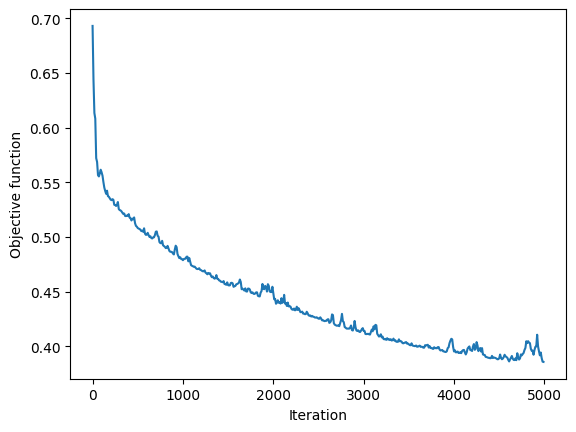

In [7]:
lamb = 0
n_iter = 5000
n_batch = 1
gamma = 0.05
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MySGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.show()

## private SGD

We will now implement and experiment with DP-SGD:
1. Following the model of the function `sgd`, implement a new function `private_sgd` which implements DP-SGD **with mini-batch size of 1 and no regularization**. It can take as input the desired value of $\epsilon$ and $\delta$ for the $(\epsilon,\delta)$-DP, or alternatively the standard deviation of the Gaussian noise to add at each iteration. Note: you do not need to make the objective plotting part private (this is only for monitoring).
2. Following the model of the class `MySGDLogisticRegression`, implement a new class `MyPrivateSGDLogisticRegression` which implements differentially private logistic regression trained using your DP-SGD implementation above.
3. Experiment with different values of $\epsilon$ and $\delta$, number of iterations and step size, and study the effect on the convergence of SGD as well as the test accuracy of the resulting model. Describe your observations. How should the number of iterations depend on the level of privacy? How can we choose the number of iterations and step size in practice?

In [8]:
def private_sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None, noise_multiplier=0.1):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """
    
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]
    
    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma
    
    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)
        
        # TO COMPLETE
        batch_indice = rng.randint(0, n, n_batch)
        _, grad = obj_and_grad(theta, X[batch_indice, :], y[batch_indice])
        # privitize step
        grad += noise_multiplier * np.random.randn(*grad.shape)
        theta -= gamma * grad
        
    return theta, obj_list


class MyPrivateSGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]
    
    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic
        
    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """
    
    def __init__(self, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, noise_multiplier=0.1, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state
        self.noise_multiplier = noise_multiplier
    
    def fit(self, X, y):
        
        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)    
                
        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = private_sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                                    self.freq_obj_eval, self.n_obj_eval, self.random_state, self.noise_multiplier)
        
        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)
        
        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list
        
        return self

Test accuracy 0.8241375780530249
Test accuracy 0.7794042378953834


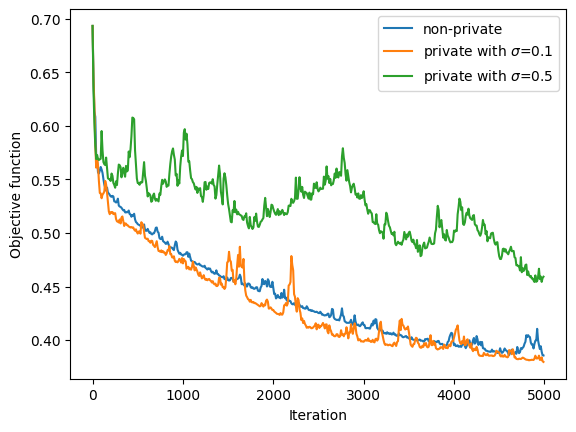

In [9]:
lamb = 0
n_iter = 5000
n_batch = 1
gamma = 0.05
# gamma = lambda t: 1 / np.sqrt(t)

private_obj_lists = []
for noise_multiplier in [0.1, 0.5]:
    mlr_private = MyPrivateSGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=None, noise_multiplier=noise_multiplier)
    mlr_private.fit(X_train, y_train)
    print("Test accuracy", mlr_private.score(X_test, y_test))
    private_obj_list = mlr_private.obj_list_
    iter_list = np.arange(len(private_obj_list)) * mlr.freq_obj_eval
    private_obj_lists.append(private_obj_list)

plt.plot(iter_list, obj_list)
for i in range(2):
    plt.plot(iter_list, private_obj_lists[i])
plt.xlabel("Iteration")
plt.ylabel("Objective function")
legends = ['non-private']
legends.extend([f'private with $\sigma$={elem}' for elem in [0.1, 0.5]])
plt.legend(legends)
plt.show()

## extending the scope of private SGD

Let us consider the following extensions:
1. *$\ell_2$-regularization*: What is the sensitivity of the stochastic gradient when adding $\ell_2$-regularization to the objective (parameter `lamb` in the code above) ? Adapt your code if needed.
2. *Mini-batch*: What is the sensitivity of a stochastic gradient when it is evaluated on a mini-batch of $b$ data points (parameter `n_batch` in the code above) ? Adapt your code if needed.
3. *Gradient clipping*: If the loss function $L$ is not Lipschitz, or when the Lipschitz constant is difficult to bound, the idea of gradient clipping consists in rescaling each individual gradient that have a norm larger than some constant $C$ to have norm equal to $C$:
$$\text{clip}(\nabla L(\theta;x,y), C) = \min\Big(1,\frac{C}{\|\nabla L(\theta;x,y)\|_2}\Big)\nabla L(\theta;x,y)$$

Explain how this allows to bound the gradient sensitivity without any assumption on the Lipschitzness of the loss. Implement this variant in a function `private_sgd_with_clipping` and explore how to choose the value of $C$ for logistic regression on the *unnormalized* version of your dataset.

In [10]:
def private_sgd_with_clipping(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None, noise_multiplier=0.1, clipping_threshold=1.0):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """
    
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]
    
    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma
    
    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)
        
        # TO COMPLETE
        batch_indice = rng.randint(0, n, n_batch)
        _, grad = obj_and_grad(theta, X[batch_indice, :], y[batch_indice])
        # clipping step
        grad = grad / np.max((1.0, clipping_threshold / np.linalg.norm(grad)))
        # privitize step
        grad += noise_multiplier * clipping_threshold * np.random.randn(*grad.shape)
        theta -= gamma * grad
        
    return theta, obj_list


class MyPrivateClippedSGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]
    
    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic
        
    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """
    
    def __init__(self, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, noise_multiplier=0.1, clipping_threshold=1.0, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state
        self.noise_multiplier = noise_multiplier
        self.clipping_threshold = clipping_threshold
    
    def fit(self, X, y):
        
        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)    
                
        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = private_sgd_with_clipping(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                                                 self.freq_obj_eval, self.n_obj_eval, self.random_state, self.noise_multiplier, self.clipping_threshold)
        
        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)
        
        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list
        
        return self

Test accuracy 0.8270037874910431
Test accuracy 0.7628211690039922


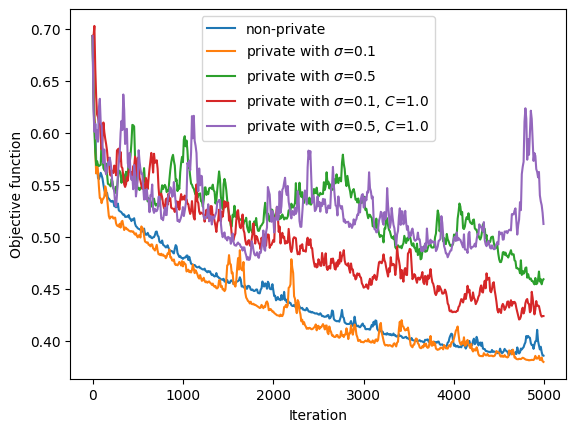

In [11]:
lamb = 0
n_iter = 5000
n_batch = 1
gamma = 0.05
# gamma = lambda t: 1 / np.sqrt(t)

private_with_clipping_obj_lists = []
for noise_multiplier in [0.1, 0.5]:
    mlr_private = MyPrivateClippedSGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=None, noise_multiplier=noise_multiplier)
    mlr_private.fit(X_train, y_train)
    print("Test accuracy", mlr_private.score(X_test, y_test))
    private_obj_list = mlr_private.obj_list_
    iter_list = np.arange(len(private_obj_list)) * mlr.freq_obj_eval
    private_with_clipping_obj_lists.append(private_obj_list)

plt.plot(iter_list, obj_list)
for i in range(2):
    plt.plot(iter_list, private_obj_lists[i])
for i in range(2):
    plt.plot(iter_list, private_with_clipping_obj_lists[i])
plt.xlabel("Iteration")
plt.ylabel("Objective function")
legends = ['non-private']
legends.extend([f'private with $\sigma$={elem}' for elem in [0.1, 0.5]])
legends.extend([f'private with $\sigma$={elem}, $C$=1.0' for elem in [0.1, 0.5]])
plt.legend(legends)
plt.show()

Now, let us move on to the private training via DP-SGD. We will use the package `Opacus`.

For easy training, we would use `FMNIST` datasets to perform experiments. We would compare various parameter settings in DP-SGD.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from opacus import PrivacyEngine
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import time

In [ ]:
# construct dataloader
def get_fmnist_dataloader(path='./data'):
    transform = transforms.ToTensor()
    
    train_set = datasets.FashionMNIST(root=path, train=True, transform=transform, download=True)
    test_set = datasets.FashionMNIST(root=path, train=False, transform=transform, download=True)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)
    
    return train_loader, test_loader

# models - logistic regression, multi-layer perceptron
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
        
    def forward(self, inputs):
        return self.linear(self.flatten(inputs))
    
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 10)
        
    def forward(self, inputs):
        return self.linear2(F.tanh(self.linear1(self.flatten(inputs))))
    
    
# function for one loop of training
def loop(model, loader, optimizer, epoch_idx=-1, mode='train', device='cpu'):
    loss_list = []
    acc_list = []
    batch_num_samples = []
    for samples, targets in loader:
        samples = samples.to(device)
        targets = targets.to(device)
        
        preds = model(samples)
        loss = F.cross_entropy(preds, targets)
        acc = (preds.topk(1, dim=1).indices == targets.unsqueeze(1)).all(1).float().mean()
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss_list.append(loss.item())
        acc_list.append(acc.item())
        batch_num_samples.append(samples.size(0))
    
    # print([loss_list[i] * batch_num_samples[i] for i in range(len(loss_list))])
    # print(torch.sum(torch.tensor([loss_list[i] * batch_num_samples[i] for i in range(len(loss_list))])))
    loss = torch.sum(torch.tensor([loss_list[i] * batch_num_samples[i] for i in range(len(loss_list))])) / torch.sum(torch.tensor(batch_num_samples))
    acc = torch.sum(torch.tensor([acc_list[i] * batch_num_samples[i] for i in range(len(acc_list))])) / torch.sum(torch.tensor(batch_num_samples))
    print(f"Epoch {epoch_idx} - {mode:^6} loss {loss:.3f}, acc {acc:.3f}")
    return loss, acc

Below we give the conventional training setup.

In [ ]:
# conventional non-private training
def train(model_type='linear'):
    train_loader, test_loader = get_fmnist_dataloader()
    if model_type == 'linear':
        model = LinearModel()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    elif model_type == 'mlp':
        model = MLP()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
    train_loss_history, train_acc_history = [], []
    test_loss_history, test_acc_history = [], []
    for epoch_idx in range(30):
        train_loss, train_acc = loop(model, train_loader, optimizer, epoch_idx=epoch_idx, mode='train')
        with torch.no_grad():
            test_loss, test_acc = loop(model, test_loader, optimizer, epoch_idx=epoch_idx, mode='test')
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
    
    return (train_loss_history, test_loss_history), (train_acc_history, test_acc_history)

In [ ]:
plt.figure()

(fig, axes) = plt.subplots(1, 2, figsize=(10,5))
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown', 'tab:gray', 'tab:pink']

title = ["loss", 'acc']
# for i, history in enumerate(non_private_linear_history):
for i in range(len(non_private_linear_history)):
    history = non_private_linear_history[i]
    ax = axes[i]
    ax.set_title(title[i])
    epochs = [i for i in range(len(history[0]))]
    ax.plot(epochs, history[0], color=color_list[0])
    ax.plot(epochs, history[1], color=color_list[9])
    ax.axis("tight")
    ax.legend(['train', 'test'])
    
plt.show()

And the rest of codes are comparing various $(\epsilon,\delta)$.

In [ ]:
# privitize the training procedure - Opacus automatically supports ghost clipping
def train_private(model_type='linear', noise_multiplier=1.1, clipping_threshold=1.0):
    train_loader, test_loader = get_fmnist_dataloader()
    if model_type == 'linear':
        model = LinearModel()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    elif model_type == 'mlp':
        model = MLP()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=clipping_threshold,
    )
    
    train_loss_history, train_acc_history = [], []
    test_loss_history, test_acc_history = [], []
    for epoch_idx in range(30):
        train_loss, train_acc = loop(model, train_loader, optimizer, epoch_idx=epoch_idx, mode='train')
        with torch.no_grad():
            test_loss, test_acc = loop(model, test_loader, optimizer, epoch_idx=epoch_idx, mode='test')
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
    
    return (train_loss_history, test_loss_history), (train_acc_history, test_acc_history)


# explicit usage of privacy budget (epsilon, delta)
def train_private_with_privacy_budget(model_type='linear', epsilon=1.0, delta=1e-5, clipping_threshold=1.0):
    train_loader, test_loader = get_fmnist_dataloader()
    if model_type == 'linear':
        model = LinearModel()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    elif model_type == 'mlp':
        model = MLP()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        target_epsilon=epsilon,
        target_delta=delta,
        epochs=30,
        max_grad_norm=clipping_threshold,
    )
    
    train_loss_history, train_acc_history = [], []
    test_loss_history, test_acc_history = [], []
    for epoch_idx in range(30):
        train_loss, train_acc = loop(model, train_loader, optimizer, epoch_idx=epoch_idx, mode='train')
        with torch.no_grad():
            test_loss, test_acc = loop(model, test_loader, optimizer, epoch_idx=epoch_idx, mode='test')
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
    
    return (train_loss_history, test_loss_history), (train_acc_history, test_acc_history)

In [ ]:
start_time = time.time()
private_linear_history = train_private_with_privacy_budget(model_type='linear', epsilon=1.0)
print(f"Running for {time.time()-start_time} seconds.")

In [ ]:
plt.figure()

(fig, axes) = plt.subplots(1, 2, figsize=(10,5))
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown', 'tab:gray', 'tab:pink']

title = ["loss", 'acc']
# for i, history in enumerate(non_private_linear_history):
for i in range(len(non_private_linear_history)):
    np_history = non_private_linear_history[i]
    p_history = private_linear_history[i]
    ax = axes[i]
    ax.set_title(title[i])
    epochs = [i for i in range(len(history[0]))]
    ax.plot(epochs, np_history[0], color=color_list[0])
    ax.plot(epochs, np_history[1], color=color_list[9])
    ax.plot(epochs, p_history[0], color=color_list[1])
    ax.plot(epochs, p_history[1], color=color_list[4])
    ax.axis("tight")
    ax.legend(['non-private train', 'non-private test', 'private train with $\epsilon$=1', 'private test with $\epsilon$=1'])
    
plt.show()

In [ ]:
start_time = time.time()
private_linear_history_8 = train_private_with_privacy_budget(model_type='linear', epsilon=8.0)
print(f"Running for {time.time()-start_time} seconds.")

In [ ]:
plt.figure()

(fig, axes) = plt.subplots(1, 2, figsize=(10,5))
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown', 'tab:gray', 'tab:pink']

title = ["loss", 'acc']
# for i, history in enumerate(non_private_linear_history):
for i in range(len(non_private_linear_history)):
    np_history = private_linear_history_8[i]
    p_history = private_linear_history[i]
    ax = axes[i]
    ax.set_title(title[i])
    epochs = [i for i in range(len(history[0]))]
    ax.plot(epochs, np_history[0], color=color_list[6])
    ax.plot(epochs, np_history[1], color=color_list[2])
    ax.plot(epochs, p_history[0], color=color_list[1])
    ax.plot(epochs, p_history[1], color=color_list[4])
    ax.axis("tight")
    ax.legend(['private train with $\epsilon$=8', 'private test with $\epsilon$=8', 'private train with $\epsilon$=1', 'private test with $\epsilon$=1'])
    
plt.show()

In [ ]:
start_time = time.time()
mlp_clipping_2 = train_private(model_type='mlp', clipping_threshold=2.0)
print(f"Running for {time.time()-start_time} seconds.")

In [ ]:
plt.figure()

(fig, axes) = plt.subplots(1, 2, figsize=(10,5))
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown', 'tab:gray', 'tab:pink']

title = ["loss", 'acc']
# for i, history in enumerate(non_private_linear_history):
for i in range(len(non_private_linear_history)):
    np_history = mlp_clipping_1[i]
    p_history = mlp_clipping_2[i]
    ax = axes[i]
    ax.set_title(title[i])
    epochs = [i for i in range(len(history[0]))]
    ax.plot(epochs, np_history[0], color=color_list[6])
    ax.plot(epochs, np_history[1], color=color_list[2])
    ax.plot(epochs, p_history[0], color=color_list[1])
    ax.plot(epochs, p_history[1], color=color_list[4])
    ax.axis("tight")
    ax.legend(['train with clipping threshold $C$=1.0', 'test with clipping threshold $C$=1.0', 'train with clipping threshold $C$=2.0', 'test with clipping threshold $C$=2.0'])
    
plt.show()

## References

1. Some codes from `Privacy preserving ML contents` from Aurélien Bellet, http://researchers.lille.inria.fr/abellet/teaching/private_machine_learning_course.html
2. Abadi et al., Deep learning with differential privacy, CCS 2016.
3. Carlini et al., Membership inference attacks from first principles, IEEE Symposium on Security and Privacy 2022.
4. Geiping et al., Inverting gradients -- how easy is it to break privacy in federated learning?, NeurIPS 2020.